# Q2.2 Train a Tokenizer

In [16]:
#TODO task1: Tokenizer Training using BPE
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace    
from tokenizers.trainers import BpeTrainer

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=6000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train(files=["data.txt"], trainer=trainer)

# Q2.3 Train a Word Embedding Model

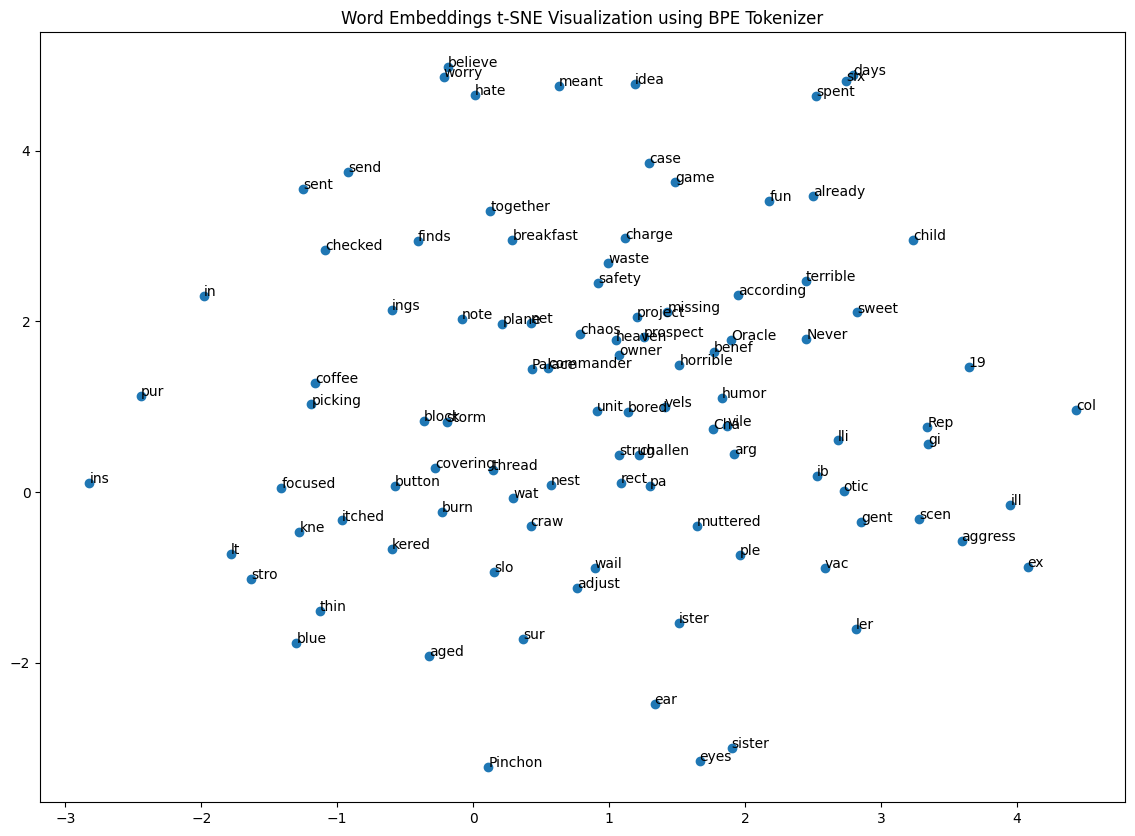

In [17]:
#TODO task2: Train a word embedding model using CBOW
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy as np

random.seed(114)
np.random.seed(514)

with open('data.txt', 'r', encoding='utf-8') as file:
    data = file.readlines()

sentences = [tokenizer.encode(line.strip()).tokens for line in data]

word2vec_model = Word2Vec(sentences, vector_size = 100, window=5, min_count=10, sg=0, workers=1, seed=0)

words = list(word2vec_model.wv.index_to_key)
random_words = random.sample(words,100)

word_vectors = np.array([word2vec_model.wv[word] for word in random_words])

# TODO visualization
tsne = TSNE(n_components=2, random_state=114)
word_vectors_tsne = tsne.fit_transform(word_vectors)

plt.figure(figsize=(14, 10))

plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1])

for i, word in enumerate(random_words):
    plt.text(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], word)

plt.title("Word Embeddings t-SNE Visualization using BPE Tokenizer")
plt.show()


# Q2.4.1 BytePiece

In [18]:
# TODO task3: train a word embedding model using BytePiece
from bytepiece import Trainer, Tokenizer

class corpus:
    def __iter__(self):
        f = 'data3.txt'  
        with open(f, 'r', encoding='utf-8') as f:
            content = f.read()  
            for item in content.split('\n\n'):
                a=item.strip()
                if(a!=''):
                    yield a  

trainer = Trainer(order=6, max_vocab_size=6000, min_count=10)
trainer.train(corpus(), workers=1, batch_size=1000)
trainer.save('bytepiece.model')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Count Ngrams: 141it [00:00, 3804.64it/s]
Prune Ngrams: 100% 7/7 [00:00<00:00, 1377.96it/s]
Count Pieces: 141it [00:00, 927.57it/s] 
Prune Pieces: 100% 793/793 [00:00<00:00, 291659.34it/s]
Prune Pieces: 100% 465/465 [00:00<00:00, 298858.62it/s]
Prune Pieces: 100% 462/462 [00:00<00:00, 296703.18it/s]


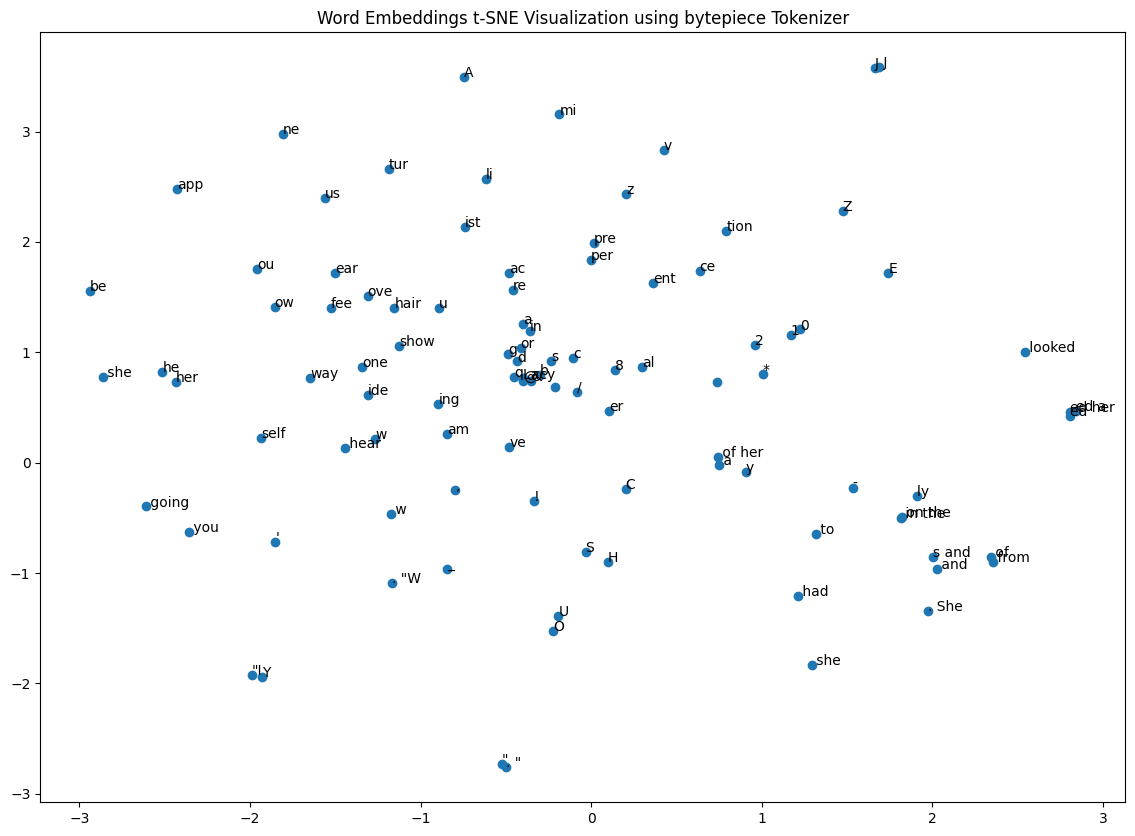

In [20]:
bytepiece_tokenizer = Tokenizer('bytepiece.model')

def load_corpus(path):
    with open(path,'r',encoding='utf-8') as f:
        content = f.read()
    return [item.strip() for item in content.split('\n\n') if item.strip()]

def tokenize_corpus(corpus):
    return [[token.decode('utf-8', errors='ignore') for token in bytepiece_tokenizer.tokenize(text)] for text in corpus]

corpus = load_corpus('data.txt')
tokenized_corpus = tokenize_corpus(corpus)

bytepiece_model = Word2Vec(tokenized_corpus, vector_size = 100, window=5, min_count=10, sg=0, workers=1, seed=0)

words_bytepiece = list(bytepiece_model.wv.index_to_key)
random_words_bytepiece = random.sample(words_bytepiece,100)

word_vectors_bytepiece = np.array([bytepiece_model.wv[word] for word in random_words_bytepiece])

# TODO: 2D visualization using t-SNE
tsne = TSNE(n_components=2, random_state=114)  # Change to 2 components for 2D
word_vectors_tsne_bytepiece = tsne.fit_transform(word_vectors_bytepiece)

plt.figure(figsize=(14, 10))

plt.scatter(word_vectors_tsne_bytepiece[:, 0], word_vectors_tsne_bytepiece[:, 1])

for i, word in enumerate(random_words_bytepiece):
    plt.text(word_vectors_tsne_bytepiece[i, 0], word_vectors_tsne_bytepiece[i, 1], word)

plt.title("Word Embeddings t-SNE Visualization using bytepiece Tokenizer")
plt.show()

# Q2.4.2 Hand-written Implementation

In [32]:
#TODO BPE Tokenizer
class BPE():
    
    def __init__(self, corpus, vocab_size):
        self.corpus = corpus
        self.vocab_size = vocab_size
        
        # 用于存储词频、切分和合并规则
        self.word_freqs = defaultdict(int)
        self.splits = {}
        self.merges = {}
    
    
    def train(self):
        # 计算语料库中每个单词的频率
        for text in self.corpus:
            # 自定义的预分词方法：按空格分词
            words_with_offsets = text.split()
            new_words = [word for word in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        alphabet = []
        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()

        # 在词汇表的开头添加特殊标记 </w>
        vocab = ["</w>"] + alphabet.copy()

        # 在训练之前将每个单词拆分为单个字符
        self.splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        # 迭代合并最频繁的字符对，直到达到所需的词汇大小
        while len(vocab) < self.vocab_size:

            # 计算每对字符的频率
            pair_freqs = self.compute_pair_freqs()

            # 找到最频繁的字符对
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq

            # 合并最频繁的字符对
            self.splits = self.merge_pair(*best_pair)
            self.merges[best_pair] = best_pair[0] + best_pair[1]
            vocab.append(best_pair[0] + best_pair[1])
        return self.merges


    def compute_pair_freqs(self):
        """计算每对字符的频率。"""

        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs


    def merge_pair(self, a, b):
        """合并给定的字符对。"""

        for word in self.word_freqs:
            split = self.splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            self.splits[word] = split
        return self.splits
    

    def tokenize(self, text):

        pre_tokenized_text = text.split()
        splits_text = [[l for l in word] for word in pre_tokenized_text]

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits_text):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits_text[idx] = split
        result = sum(splits_text, [])
        return result 

In [33]:
# TODO Word2Vec Embedding
from collections import defaultdict
 
class word2vec():
 
    def __init__(self):
        self.n = settings['n']
        self.lr = settings['learning_rate']
        self.epochs = settings['epochs']
        self.window = settings['window_size']
 
    def generate_training_data(self, settings, corpus):

        #defaultdict(int)  一个字典，当所访问的键不存在时，用int类型实例化一个默认值
        word_counts = defaultdict(int)
 
        for row in corpus:
            for word in row:
                #统计每个单词出现的次数
                word_counts[word] += 1
 
        # 词汇表的长度
        self.v_count = len(word_counts.keys())
        # 在词汇表中的单词组成的列表
        self.words_list = list(word_counts.keys())
        # 以词汇表中单词为key，索引为value的字典数据
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        #以索引为key，以词汇表中单词为value的字典数据
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))
 
        training_data = []
 
        for sentence in corpus:
            sent_len = len(sentence)
 
            for i, word in enumerate(sentence):
 
                w_target = self.word2onehot(sentence[i])
 
                w_context = []
 
                for j in range(i - self.window, i + self.window):
                    if j != i and j <= sent_len - 1 and j >= 0:
                        w_context.append(self.word2onehot(sentence[j]))
 
                training_data.append([w_target, w_context])
 
        return training_data
 
    def word2onehot(self, word):
 
        #将词用onehot编码
 
        word_vec = [0 for i in range(0, self.v_count)]
 
        word_index = self.word_index[word]
 
        word_vec[word_index] = 1
 
        return word_vec
 
    def train(self, training_data):
 
 
        #随机化参数w1,w2
        self.w1 = np.random.uniform(-1, 1, (self.v_count, self.n))
 
        self.w2 = np.random.uniform(-1, 1, (self.n, self.v_count))
 
        for i in range(self.epochs):
 
            self.loss = 0
 
            # w_t 是表示目标词的one-hot向量
            #w_t -> w_target,w_c ->w_context
            for w_t, w_c in training_data:
 
                #前向传播
                y_pred, h, u = self.forward(w_t)
 
                #计算误差
                EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)
 
                #反向传播，更新参数
                self.backprop(EI, h, w_t)
 
                #计算总损失
                self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))
 
            print('Epoch:', i, "Loss:", self.loss)
 
    def forward(self, x):
 
        h = np.dot(self.w1.T, x)
 
        u = np.dot(self.w2.T, h)
 
        y_c = self.softmax(u)
 
        return y_c, h, u
 
 
    def softmax(self, x):
        """
        """
        e_x = np.exp(x - np.max(x))
 
        return e_x / np.sum(e_x)
 
 
    def backprop(self, e, h, x):
 
        d1_dw2 = np.outer(h, e)
        d1_dw1 = np.outer(x, np.dot(self.w2, e.T))
 
        self.w1 = self.w1 - (self.lr * d1_dw1)
        self.w2 = self.w2 - (self.lr * d1_dw2)
 
    def word_vec(self, word):
 
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
 
        return v_w
 
    def vec_sim(self, word, top_n):
 
        v_w1 = self.word_vec(word)
        word_sim = {}
 
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_sum = np.dot(v_w1, v_w2)
 
            #np.linalg.norm(v_w1) 求范数 默认为2范数，即平方和的二次开方
            theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = theta_sum / theta_den
 
            word = self.index_word[i]
            word_sim[word] = theta
 
        words_sorted = sorted(word_sim.items(), key=lambda kv: kv[1], reverse=True)
 
        for word, sim in words_sorted[:top_n]:
            print(word, sim)
 
    def get_w(self):
        w1 = self.w1
        return  w1
#超参数
settings = {
    'window_size': 2,  
    #单词嵌入(word embedding)的维度,维度也是隐藏层的大小。
    'n': 10,
    'epochs': 50,         
    'learning_rate':0.01 
}


In [34]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return [line.strip().lower() for line in data if line.strip()]

data = load_data('data.txt')
#print(f"Loaded {len(data)} lines of text.")

In [36]:
bpe_vocab_size = 600  # You can adjust this value based on your needs

bpe_tokenizer = BPE(corpus=data, vocab_size=bpe_vocab_size)
bpe_merges = bpe_tokenizer.train()


In [11]:

tokenized_corpus = [bpe_tokenizer.tokenize(line) for line in data]

w2v_model = word2vec()
training_data = w2v_model.generate_training_data(settings, tokenized_corpus)

w2v_model.train(training_data)


Epoch: 0 Loss: 143812.45434617443
Epoch: 1 Loss: 139941.1313426587
Epoch: 2 Loss: 137158.17222972162
Epoch: 3 Loss: 133810.92519122944
Epoch: 4 Loss: 130302.90862067367
Epoch: 5 Loss: 127356.99162840925
Epoch: 6 Loss: 125017.16824202155
Epoch: 7 Loss: 123183.65393283087
Epoch: 8 Loss: 121733.79922956463
Epoch: 9 Loss: 120567.26216601132
Epoch: 10 Loss: 119610.70089207483
Epoch: 11 Loss: 118810.64749490807
Epoch: 12 Loss: 118128.45477680977
Epoch: 13 Loss: 117536.07385353708
Epoch: 14 Loss: 117012.78692078208
Epoch: 15 Loss: 116543.11310548463
Epoch: 16 Loss: 116115.45064017968
Epoch: 17 Loss: 115721.12643815247
Epoch: 18 Loss: 115353.68191905187
Epoch: 19 Loss: 115008.31258344295
Epoch: 20 Loss: 114681.4314303253
Epoch: 21 Loss: 114370.33961703035
Epoch: 22 Loss: 114072.98496059144
Epoch: 23 Loss: 113787.78764735004
Epoch: 24 Loss: 113513.51504347858
Epoch: 25 Loss: 113249.19150552244
Epoch: 26 Loss: 112994.03292768884
Epoch: 27 Loss: 112747.39880422837
Epoch: 28 Loss: 112508.756788527

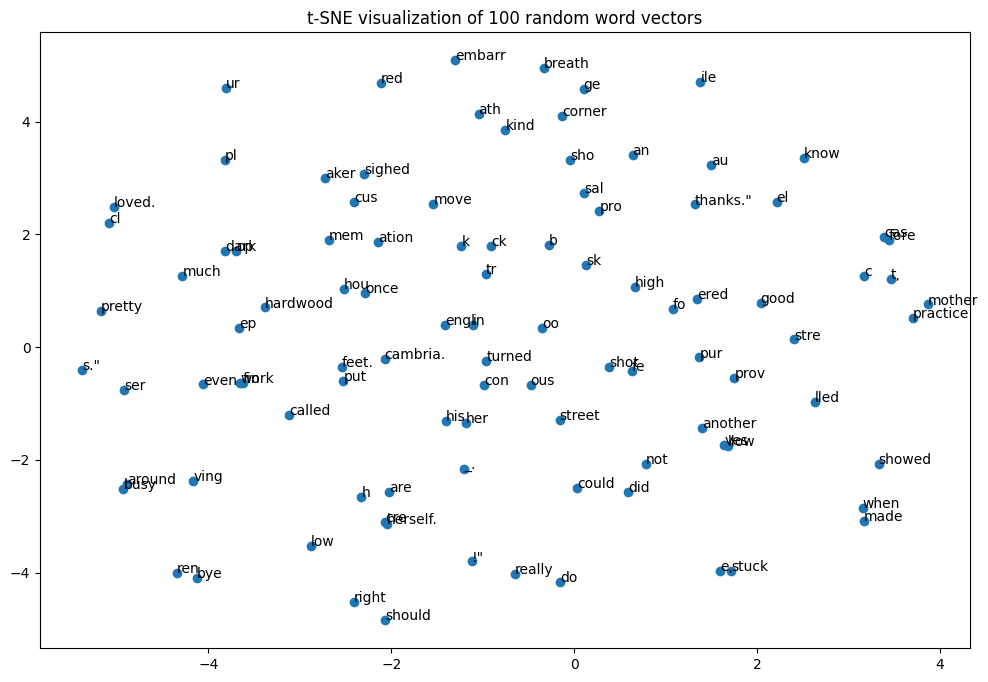

In [12]:
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

random_tokens = random.sample(w2v_model.words_list, 100)

vectors = np.array([w2v_model.word_vec(token) for token in random_tokens])

tsne_model = TSNE(n_components=2, random_state=42)
tsne_result = tsne_model.fit_transform(vectors)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

for i, token in enumerate(random_tokens):
    plt.annotate(token, (tsne_result[i, 0], tsne_result[i, 1]))

plt.title("t-SNE visualization of 100 random word vectors")
plt.show()